In [1]:
# Load the data set
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pprint import pprint
import random
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

train_data = pd.read_csv('./data/train.csv')
test_data= pd.read_csv('./data/test.csv')

train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Shared Functions

In [2]:
from collections import OrderedDict
import json
data_fields = OrderedDict()


def add_component(key):
    k,*v = key.split(': ')
    data_fields[k] = {
        'description': v[0],
        'components':{}
    }

    while '   ' in content[0]:
#         print(_)
        enrich_component(k, content.pop(0))
        if len(content)==0:
            break
    
    return k


def enrich_component(key, value:str):
    if value == "":
        return
    _ = value.strip().split(":")
    k,v = _[0],_[1]
    data_fields[key]['components'][k.upper()]=v.strip()

# with open('./data/data_description.md', 'r') as f:
#     content = list(f.readlines())
#     _content = map(lambda i:i.replace('\n','').replace('\t\t','').replace('\t',': '),content)
#     _content = filter(lambda j:j!=''and j!=': ', _content)
#     content = list(_content)
# #     pprint(content)
#     while len(content)>0:
#         current_k = add_component(content.pop(0))
# #         print(current_k)
        
#         if len(content)==0:
#             break
            
def show_fields():
    for k in data_fields.keys():
        print(f'{k}\t–\tDescription: {data_fields[k]["description"]}')
        if len(data_fields[k]['components'])>0:
            print('Components\n', *list(f'\t- {i}: {j}\n' for i,j in data_fields[k]['components'].items()))
        print('============')
def plot_category(y_field, x_field:str="SalePrice"):
    sns.set(style="ticks", color_codes=True)
    g = sns.catplot(x=x_field, y=y_field, data=train_data);
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)


def get_color(existing_color=[])->str:
    r = lambda: random.randint(0,255)
    _color = '#%02X%02X%02X' % (r(),r(),r())
    _ = get_color(existing_color) if _color in existing_color else _color
    existing_color.append(_)
    return _

def plot_with_category(x_field:str, y_field:str='SalePrice'):
    y = train_data[y_field]
    x = pd.get_dummies(train_data[x_field])
    category = list(set(x.columns))
#     print(category, data_fields[x_field]["components"])
    chosen_color = []

    for c in category:
        # Plot outputs
        plt.scatter(x[c], y,  color=get_color(chosen_color))
        plt.title(label=f'{y_field} with respect to {data_fields[x_field]["components"][c.upper()]}')
#         plt.title(label=f'{y_field} with respect to {c}')
        # plt.plot(x, y, color='blue', linewidth=3)
        plt.show()

def pure_plot(x_field:str, y_field:str='SalePrice'):
    # Plot outputs
    plt.scatter(train_data[x_field], train_data[y_field],  color=get_color())
#     plt.plot(x, y, color='blue', linewidth=3)
    plt.show()
    

def plot(x_field:str, y_field:str='SalePrice'):
#     print(f'Field: {x_field}\nDescription: {data_fields[x_field]["description"]}')
#     print('Components\n', *list(f'- {i}: {j}\n' for i,j in data_fields[x_field]['components'].items()))
    plot_category(x_field=y_field, y_field=x_field) if is_string_dtype(train_data[x_field]) else pure_plot(x_field, y_field)

def plot_heap_map_corr(data:pd.DataFrame, save:bool=True):

    # import matplotlib.pyplot as plt
    sns.set(style="white")

    # Generate a large random dataset
#     rs = np.random.RandomState(33)

    # Compute the correlation matrix
    corr = data.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure <- for adjust the size
    f, ax = plt.subplots(figsize=(40, 40))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    h_map = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,annot=True)
    if save:
        h_map.figure.savefig("correlation.png")
        
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
def basic_data_set_info(train_data, test_data):
    num_train_data = train_data.shape[0]
    num_test_data = test_data.shape[0]
    print(f'Total record is {num_train_data+num_test_data}')
    print(f'Training set is {num_train_data}')
    print(f'Testing set is {num_test_data}')
    all_data = train_data.append(test_data,sort=False, ignore_index=True)
    print(f'Number of duplication (by id) is {all_data.shape[0] - len(set(all_data.Id))}')
    print(f'Number of features (except target prediction value): {all_data.shape[1]-1}')
    # 
    features = list(all_data.columns)
    features.remove('Id')
    features.remove('SalePrice')
    missing = (all_data[features].isnull().sum()/all_data[features].isnull().count()).sort_values(ascending=False)
    missing = pd.DataFrame({'Missing – NA(%)':round(missing[missing>0]*100,2)})
    print(missing.head(n=100))
    print(f'\n{missing.shape[0]} features have missing data')
#     missing_quant = (all_data[quantity].isnull().sum()/data_all[quantity].isnull().count()).sort_values(ascending=False)
#     missing_quant = missing_quant[missing_quant > 0] * 100
#     print("There are {} quantitative features with  missing values :".format(missing_quant.shape[0]))
#     missing_quant = pd.DataFrame({'Percent' :missing_quant})
#     missing_quant.head()
#     return train_data.copy()
    _ = all_data.copy()
#     print(all_data[all_data.Id==2127]['SalePrice'])
    return _

def convert_to_ordinary(all_data, order_val, field):
    print(f'{field} values: {set(all_data[field].values)}')
    valmap = {v:i for i,v in enumerate(order_val)}
    all_data[field] = all_data[field].replace(valmap)
    return all_data[field]

def fillna_by_mode(all_data, field:str):
    return all_data[field].fillna(all_data[field].mode().iloc[0])

def fillna_by_mean(all_data, field:str):
    return all_data[field].fillna(all_data[field].mean())

def fillna_by_median(all_data, field:str):
    return all_data[field].fillna(all_data[field].median())

def fillna_by_str(all_data, field:str, content:str="NA"):
    return all_data[field].fillna(content)

def label_encoding(all_data, field):
    '''
    For discrete order
    '''
    labelencoder = LabelEncoder()
    all_data['field'] = labelencoder.fit_transform(all_data['field'])
    return all_data.copy()

def one_hot_encoding(data_set, fields:list=None):
    '''
    For discrete unorder
    '''
    return pd.get_dummies(data_set, columns=fields)
    

def drop_col(data, cols:list):
    return data.drop(cols, axis=1)

def show_na_count(field):
    print(f'{field}: {len(all_data[field][all_data[field].isnull()])}')
    

# Evaluate the data quality

In [5]:
all_data = basic_data_set_info(train_data, test_data)

Total record is 2919
Training set is 1460
Testing set is 1459
Number of duplication (by id) is 0
Number of features (except target prediction value): 80
              Missing – NA(%)
PoolQC                  99.66
MiscFeature             96.40
Alley                   93.22
Fence                   80.44
FireplaceQu             48.65
LotFrontage             16.65
GarageCond               5.45
GarageQual               5.45
GarageYrBlt              5.45
GarageFinish             5.45
GarageType               5.38
BsmtCond                 2.81
BsmtExposure             2.81
BsmtQual                 2.77
BsmtFinType2             2.74
BsmtFinType1             2.71
MasVnrType               0.82
MasVnrArea               0.79
MSZoning                 0.14
BsmtHalfBath             0.07
Utilities                0.07
Functional               0.07
BsmtFullBath             0.07
BsmtFinSF2               0.03
BsmtFinSF1               0.03
Exterior2nd              0.03
BsmtUnfSF                0.03
TotalBs

# Data Engineering

In [3]:
all_data = basic_data_set_info(train_data, test_data)
#
# from float type to int type
all_data[['GarageYrBlt','YearBuilt']]
_ = pd.DataFrame({'diff': all_data['GarageYrBlt']-all_data['YearBuilt']})

# print(f'Similarity GarageYrBlt and YearBuilt:{(_[ _["diff"]==0 ].count()/_.shape[0] *100)}%\n')

# Fillna by other field
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(all_data['YearBuilt'])
all_data[['GarageYrBlt','YearBuilt']]
all_data.GarageYrBlt = all_data.GarageYrBlt.astype(int)

# all_data[['GarageYrBlt','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual']]

# Since the missing rate of Garage* features are very similar, we may check if they have the phenomon -> the garage may not really exist
# Filter out one of the null field
set_159 = all_data[
#     all_data['GarageType'].isnull()
    all_data['GarageFinish'].isnull()
#     all_data['GarageCond'].isnull()&
#     all_data['GarageQual'].isnull()
][['Id','GarageYrBlt','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual', 'GarageArea', 'GarageCars']]


set_157 = all_data[
    all_data['GarageType'].isnull()&
    all_data['GarageFinish'].isnull()&
    all_data['GarageCond'].isnull()&
    all_data['GarageQual'].isnull()
][['Id','GarageYrBlt','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual', 'GarageArea', 'GarageCars']]


print(f'Bias Id: {set(set_159.Id) - set(set_157.Id)}')

# Seems 2127 has carage while 2577 no
set_159[(set_159.Id == 2577) | (set_159.Id == 2127) ]

# Clean 2127
# all_data[all_data.Id==2127] = all_data[all_data.Id==2127].fillna(all_data.mode().iloc[0])

# Fill na to be factor
all_data.GarageType = all_data.GarageType.fillna('NA')

# Id 2577 -> NA for GarageCars, GarageArea and deteached ->GarageType, simple check to no garage
all_data[all_data.GarageCars.isnull()][['Id', 'GarageCars', 'GarageArea', 'GarageType']]
all_data.loc[2577-1,'GarageCars'] = 0
all_data.loc[2577-1,'GarageArea'] = 0
all_data.loc[2577-1,'GarageType'] = 'NA'
all_data[all_data.Id==2577][['Id', 'GarageCars', 'GarageArea', 'GarageType']]

# Convert the ordinal value
all_data.GarageFinish = convert_to_ordinary(all_data, [np.NaN, 'Unf', 'RFn', 'Fin'], 'GarageFinish')
all_data.GarageQual = convert_to_ordinary(all_data, [np.NaN, 'Po', 'Fa', 'TA','Gd','Ex'], 'GarageQual')
all_data.GarageCond = convert_to_ordinary(all_data, [np.NaN, 'Po', 'Fa', 'TA','Gd','Ex'], 'GarageCond')


# encode this variable as the values are ordinal

# Check the PoolArea
all_data.PoolQC = convert_to_ordinary(all_data, [np.NaN, 'Fa', 'TA','Gd','Ex'], 'PoolQC')

# There are 3 records that have PoolArea but do not have PoolQC -> consider to use the linear regression for OverallQual and PoolQC
all_data[(all_data.PoolQC==0)& (all_data.PoolArea>0)][['PoolQC', 'PoolArea', 'OverallQual']]
# By plotting the chat, we can see the trend PoolQC is matched with OverallQual
# plot(y_field='OverallQual', x_field='PoolQC')


# Handling MiscFeature, to eliminate the None value for future processing
all_data.MiscFeature = all_data.MiscFeature.fillna('None')
# x = sns.barplot(x="MiscFeature", y="SalePrice", data=all_data)

# Within Fireplace Quality, there are 1420 NAs. Number of fireplaces is complete.
print(f'Missing Fireplace is match: {all_data.Fireplaces[all_data.Fireplaces==0].count() == len(all_data.FireplaceQu[all_data.FireplaceQu.isnull()])}')
all_data.FireplaceQu = convert_to_ordinary(all_data, [np.NaN, 'Po', 'Fa', 'TA','Gd','Ex'], 'FireplaceQu')


all_data['Functional'] = fillna_by_mode(all_data, field='Functional')
# all_data.Functional[all_data.Functional.isnull()
all_data.Functional = convert_to_ordinary(all_data, ['Sal', 'Sev', 'Maj2','Maj1','Mod','Min2','Min1','Typ'], 'Functional')
# plot('Functional')


all_data['SaleType'] = fillna_by_mode(all_data, field='SaleType')
# plot('SaleType')

# `KitchenAbvGr` is no NA nad 1NA in KitchenQual
len(all_data.KitchenQual[all_data.KitchenQual.isnull()])
all_data['KitchenQual'] = fillna_by_mode(all_data, field='KitchenQual')
all_data.KitchenQual = convert_to_ordinary(all_data, ['Po', 'Fa', 'TA','Gd','Ex'], 'KitchenQual')
# all_data.KitchenAbvGr
# set(all_data.columns)
# plot(x_field='KitchenAbvGr')
# plot('KitchenQual')

# Since the NA is no pool -> convert to ordinary
all_data.Fence = convert_to_ordinary(all_data, [np.NaN, 'MnWw', 'GdWo','MnPrv','GdPrv'], 'Fence')
# plot('Fence')

# Electrical ->1 NA, fill by Mode
len(all_data.Electrical[all_data.Electrical.isnull()])
all_data['Electrical'] = fillna_by_mode(all_data, field='Electrical')
# plot('Electrical')

# all_data.Fence[all_data.Fence.isnull()]


# Type of alley access to property -> NA mean no alley access
all_data.Alley = fillna_by_str(all_data, field='Alley', content="NA")

# Value of LotShape is ordinal -> convert it
all_data.LotShape = convert_to_ordinary(all_data, ['IR3', 'IR2','IR1','Reg'], 'LotShape')

# The people who live nearby have the similar LotFrontage -> surrounding linear feet of stree is similar
all_data.LotFrontage = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

print('---')
# Seems these related vairables have the similar result -> Mean no basement?
for bsmt in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtHalfBath', 'BsmtFullBath','BsmtFinSF2','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF']:
    show_na_count(bsmt)

bsmt_common_null = all_data[
    all_data['BsmtQual'].isnull()&
    all_data['BsmtCond'].isnull()&
    all_data['BsmtExposure'].isnull()&
    all_data['BsmtFinType1'].isnull()&
    all_data['BsmtFinType2'].isnull()
][['Id','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]

# We have 37 is NA
len(bsmt_common_null)
bsmt_common_null_id = set(bsmt_common_null['Id'].values)
bsmt_exposure_null_id = set(all_data[all_data.BsmtExposure.isnull()]['Id'].values)
bsmt_fintype2_null_id = set(all_data[all_data.BsmtFinType2.isnull()]['Id'].values)
bsmt_qual_null_id = set(all_data[all_data.BsmtQual.isnull()]['Id'].values)
bsmt_cond_null_id = set(all_data[all_data.BsmtCond.isnull()]['Id'].values)

# We can find that below is the special case
print("special case for bsmt")
print(bsmt_exposure_null_id-bsmt_common_null_id) # {1488, 2349, 949}
print(bsmt_fintype2_null_id-bsmt_common_null_id) # {333}
print(bsmt_qual_null_id-bsmt_common_null_id) # {2218, 2219}
print(bsmt_cond_null_id-bsmt_common_null_id) # {2041, 2186, 2525}


def selective_fill_by_mode_bsmt(target_set, field):
    for i in target_set:
#         print(i, all_data.loc[i-1,field])
        all_data.loc[i-1,field] = all_data[all_data.BsmtExposure!='No'][field].mode().iloc[0]
#         print(all_data.loc[i-1,field])
#         print('....')


selective_fill_by_mode_bsmt(bsmt_exposure_null_id-bsmt_common_null_id, 'BsmtExposure')
selective_fill_by_mode_bsmt(bsmt_fintype2_null_id-bsmt_common_null_id, 'BsmtFinType2')
selective_fill_by_mode_bsmt(bsmt_qual_null_id-bsmt_common_null_id, 'BsmtQual')
selective_fill_by_mode_bsmt(bsmt_cond_null_id-bsmt_common_null_id, 'BsmtCond')

# and convert to ordinal 
all_data.BsmtQual = convert_to_ordinary(all_data, [np.NaN, 'Po','Fa','TA','Gd', 'Ex'],'BsmtQual')
all_data.BsmtCond = convert_to_ordinary(all_data, [np.NaN, 'Po','Fa','TA','Gd', 'Ex'],'BsmtCond')
all_data.BsmtExposure = convert_to_ordinary(all_data, [np.NaN, 'No','Mn','Av','Gd'],'BsmtExposure')
all_data.BsmtFinType1 = convert_to_ordinary(all_data, [np.NaN, 'Unf','LwQ','Rec','BLQ','ALQ','GLQ'],'BsmtFinType1')
all_data.BsmtFinType2 = convert_to_ordinary(all_data, [np.NaN, 'Unf','LwQ','Rec','BLQ','ALQ','GLQ'],'BsmtFinType2')


all_data[all_data.BsmtHalfBath.isnull()][['Id','BsmtQual','BsmtHalfBath', 'BsmtFullBath','BsmtFinSF2','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF']]
all_data.BsmtHalfBath.fillna(0, inplace=True)

all_data[all_data.BsmtHalfBath.isnull()][['Id','BsmtQual','BsmtHalfBath', 'BsmtFullBath','BsmtFinSF2','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF']]
all_data.BsmtHalfBath.fillna(0, inplace=True)
all_data.BsmtFullBath.fillna(0, inplace=True)
all_data.BsmtFinSF2.fillna(0, inplace=True)
all_data.BsmtFinSF1.fillna(0, inplace=True)
all_data.BsmtUnfSF.fillna(0, inplace=True)
all_data.TotalBsmtSF.fillna(0, inplace=True)

# all_data.BsmtExposure.fillna()

# MasVnrType and MasVnrArea should be coexist
show_na_count('MasVnrType') # 24
show_na_count('MasVnrArea') # 23

# 2611 is not aligned
all_data[all_data.MasVnrType.isnull() | all_data.MasVnrArea.isnull()][['Id','MasVnrType','MasVnrArea']]

all_data.loc[2611-1,'MasVnrType'] = all_data['MasVnrType'].mode().iloc[0]
# all_data.MasVnrType = fillna_by_str(all_data,  field='MasVnrType', content='None')
all_data.MasVnrType = convert_to_ordinary(all_data, [np.NaN, 'BrkCmn','BrkFace','Stone'],'MasVnrType')

all_data.MasVnrArea.fillna(0, inplace=True)

all_data.MSZoning = fillna_by_mode(all_data, 'MSZoning')
all_data.Exterior1st = fillna_by_mode(all_data, 'Exterior1st')
all_data.Exterior2nd = fillna_by_mode(all_data, 'Exterior2nd')

all_data.ExterQual = convert_to_ordinary(all_data, ['Po','Fa','TA','Gd', 'Ex'],'ExterQual')
all_data.ExterCond = convert_to_ordinary(all_data, ['Po','Fa','TA','Gd', 'Ex'],'ExterCond')

# all_data.shape
all_data.loc[2610,'MasVnrType']

# Same Street should have similar utilities
all_data.Utilities = all_data.groupby('Street')['Utilities'].transform(lambda x:x.fillna(x.mode().iloc[0]))


# 

# ==================================================================
all_data.to_pickle("./all_data_no_missing_no_combine.pkl")
train_data_set = all_data[0:1459].copy()
test_data_set = all_data[1460:].copy()
# train_data_set = train_data_set.drop(['Id'], axis=1)

# basic_data_set_info(train_data_set, test_data_set)
# plot_heap_map_corr(train_data_set)

# from dataprep.eda import create_report
# report = create_report(data_set, title='Clean Report')


Total record is 2919
Training set is 1460
Testing set is 1459
Number of duplication (by id) is 0
Number of features (except target prediction value): 80
              Missing – NA(%)
PoolQC                  99.66
MiscFeature             96.40
Alley                   93.22
Fence                   80.44
FireplaceQu             48.65
LotFrontage             16.65
GarageCond               5.45
GarageQual               5.45
GarageYrBlt              5.45
GarageFinish             5.45
GarageType               5.38
BsmtCond                 2.81
BsmtExposure             2.81
BsmtQual                 2.77
BsmtFinType2             2.74
BsmtFinType1             2.71
MasVnrType               0.82
MasVnrArea               0.79
MSZoning                 0.14
BsmtHalfBath             0.07
Utilities                0.07
Functional               0.07
BsmtFullBath             0.07
BsmtFinSF2               0.03
BsmtFinSF1               0.03
Exterior2nd              0.03
BsmtUnfSF                0.03
TotalBs

## Combine features

In [9]:
data_set = pd.read_pickle("./all_data_no_missing_no_combine.pkl")


0        5
1       31
2        6
3       36
4        8
        ..
2914    36
2915    36
2916    10
2917    14
2918    12
Name: HouseLiveAge, Length: 2919, dtype: int64

ValueError: Can only compare identically-labeled Series objects

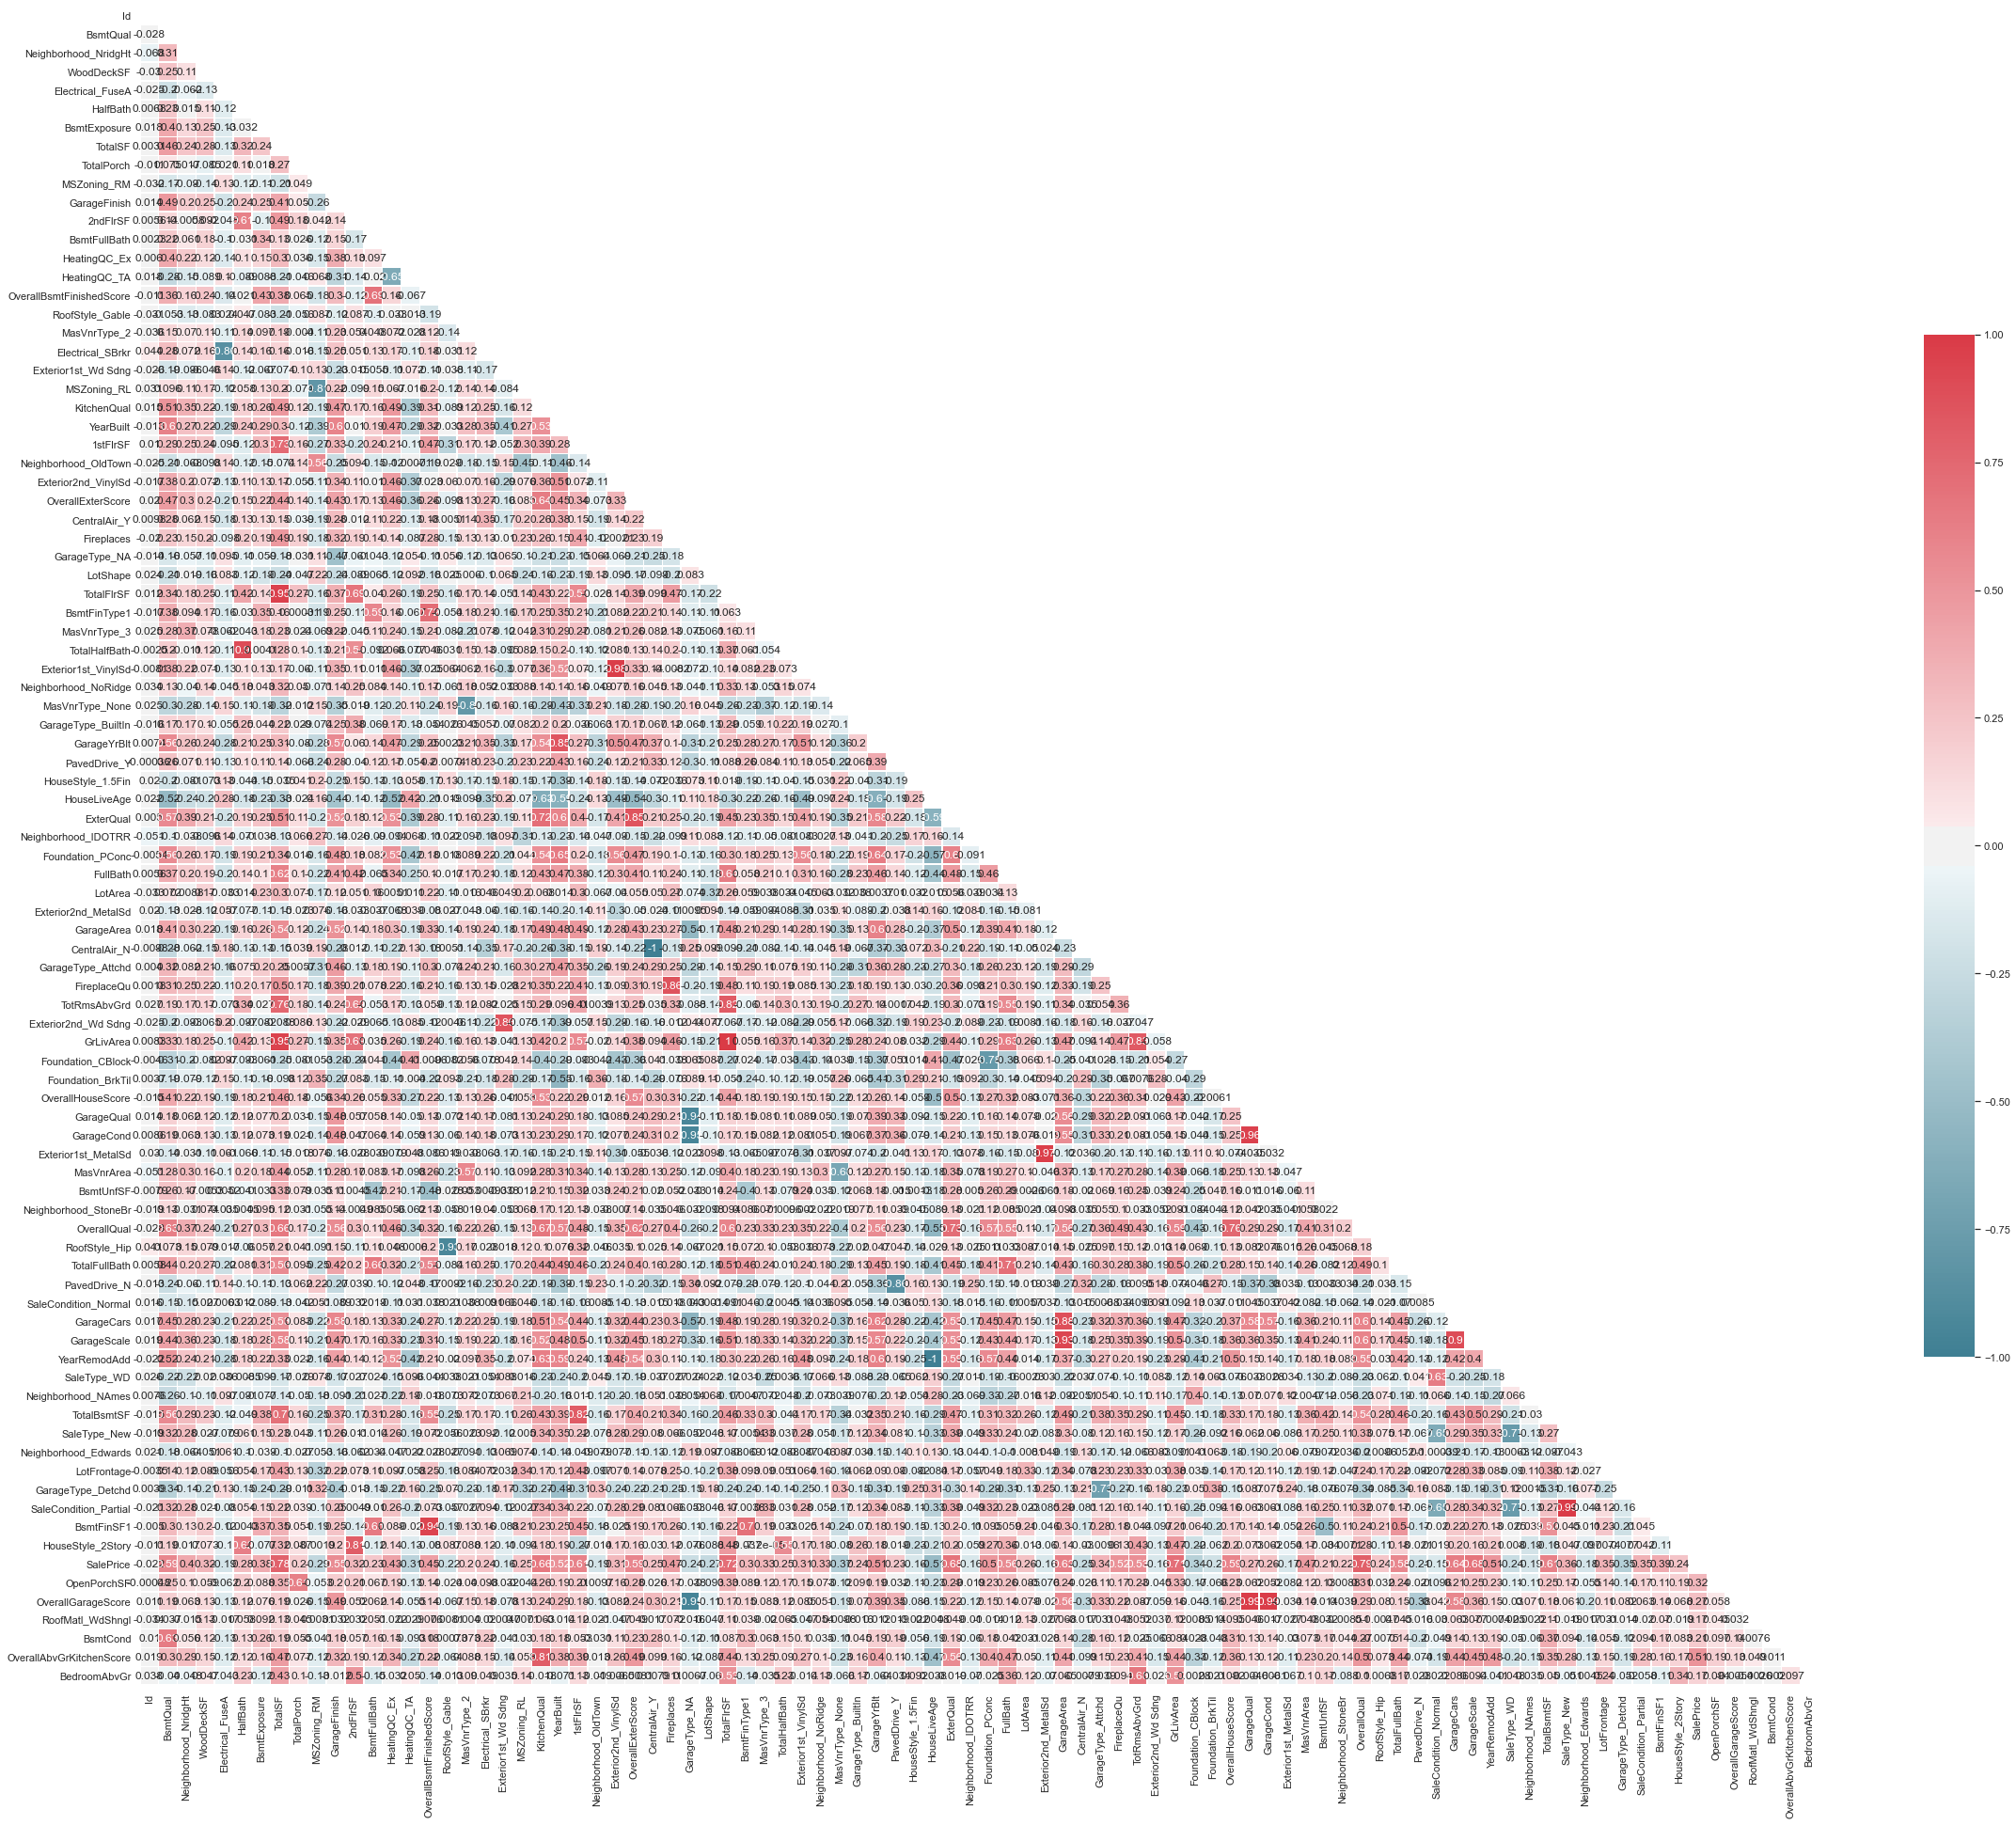

In [10]:
# Combine fetures
data_set = pd.read_pickle("./all_data_no_missing_no_combine.pkl")
full_set = data_set.copy()
data_set = data_set[0:1460].copy()


def combine_fields(df):
    # Better
    # Total Floor square feet = 1st + 2nd 
    df['TotalFlrSF'] = df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalSF'] = df['TotalBsmtSF']+df['TotalFlrSF']+df['GrLivArea']
    df['GarageScale'] = df['GarageArea']*df['GarageCars']
    df['TotalFullBath'] = df['BsmtFullBath'] + df["FullBath"] 
    df['OverallBsmtFinishedScore'] = df['BsmtFinSF1']*df['BsmtFinType1'] + df['BsmtFinSF2']*df['BsmtFinType2']
    df['Remodeled'] = df.YearBuilt == data_set.YearRemodAdd
    df['HouseLiveAge'] = df.YrSold - data_set.YearRemodAdd

    # No difference
    df['OverallGarageScore'] = df['GarageQual'] + df['GarageCond']

    # Worst
    df['OverallHouseScore'] = df['OverallQual'] + df['OverallCond']
    df['OverallExterScore'] = df['ExterQual'] + df['ExterCond']
    df['TotalHalfBath'] = df["HalfBath"] + df['BsmtHalfBath']
    df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df['OverallAbvGrKitchenScore'] = df['KitchenQual'] * df['KitchenAbvGr']
    return df


data_set = combine_fields(data_set)
# CHECKIN
# data_set['YearDiffRemodel'] = data_set['YearRemodAdd'] - data_set['YearBuilt']
# data_set = one_hot_encoding(data_set, ['MSSubClass'])


categorical_col = list(set(data_set.select_dtypes(include='object').columns))
non_categorical_col = list(set(data_set.select_dtypes(exclude='object').columns))

data_set.to_pickle("./all_data_no_missing_combine.pkl")



selected_categorical_features = []
for i in categorical_col:
    _df = one_hot_encoding(data_set[['SalePrice', i]],[i])
    _ = _df.corr().iloc[0]
    selected_categorical_features+=list(_[ (_ > 0.15) | (_ < -0.15) ].index)

selected_non_categorical_features = []
for i in non_categorical_col:
    _df = data_set[['SalePrice',i]]
    _ = _df.corr().iloc[0]
    selected_non_categorical_features+=list(_[ (_ > 0.15) | (_ < -0.15) ].index)

data_set = one_hot_encoding(data_set, categorical_col)
selected_features = list(set(selected_non_categorical_features+selected_categorical_features))
data_set = data_set[['Id']+selected_features]
plot_heap_map_corr(data_set)
data_set.to_pickle("./train_data_no_missing_combine_selected.pkl")



full_set = combine_fields(full_set)

full_set = one_hot_encoding(full_set, categorical_col)
full_set = full_set[['Id']+selected_features]

full_set.to_pickle("./full_data_no_missing_combine_selected.pkl")

# print('categorical',set(selected_categorical_features))
# print('non-categorical',set(selected_non_categorical_features))
    

# plot_heap_map_corr(full_set)
# data_set['ExterQual'].head()
# df = data_set[[
#     'TotalFlrSF',    '1stFlrSF',    '2ndFlrSF',
#     'TotalSF','TotalBsmtSF',
#     'GarageScale','GarageArea','GarageCars',
#     'TotalFullBath',    'BsmtFullBath',    'FullBath',
#     'OverallBsmtFinishedScore','BsmtFinSF1','BsmtFinType1','BsmtFinSF2','BsmtFinType2',
#     'OverallGarageScore',    'GarageQual',    'GarageCond',
#     'OverallHouseScore',    'OverallQual',    'OverallCond',
#     'OverallExterScore',    'ExterQual',    'ExterCond',
#     'TotalHalfBath',    'HalfBath',    'BsmtHalfBath',
#     'TotalPorch',    'OpenPorchSF',    'EnclosedPorch',    '3SsnPorch','ScreenPorch',
#     'OverallAbvGrKitchenScore','KitchenQual','KitchenAbvGr',
    
#     'SalePrice'    
# ]]
# plot_heap_map_corr(df)

# selected_feature_df = data_set[[
#     'TotalFlrSF',
#     'TotalSF',
#     'GarageScale',
#     'TotalFullBath',
#     'OverallBsmtFinishedScore'
#     'OverallQual',
    
    
# ]]
# data_set[['YearBuilt','YearRemodAdd']]

# data_set[[ 'OverallHouseScore','SalePrice']].corr()
